Zaproponować własną analizę i prezentację danych dotyczących leków. Można w tym celu pozyskiwać dodatkowe informacje z innych biomedycznych i bioinformatycznych baz danych dostępnych online. Należy jednak upewnić się, czy dana baza danych pozwala na zautomatyzowane pobieranie danych przez program. Na przykład baza danych GeneCards wprost tego zabrania, co zostało na czerwono podkreślone na tej stronie. Przykładowe bazy danych to:
- [UniProt](https://www.uniprot.org/),
- [Small Molecule Pathway Database](https://smpdb.ca/),
- [The Human Protein Atlas](https://www.proteinatlas.org/).

In [1]:
import pandas as pd
from lxml import etree
import networkx as nx
import matplotlib.pyplot as plt
from pprint import pprint

import pydot
from networkx.drawing.nx_pydot import graphviz_layout

In [2]:
path = 'data/drugbank_partial.xml'
ns = {'db': 'http://www.drugbank.ca'}

In [3]:
tree = etree.parse(path)
root = tree.getroot()

In [4]:
def unwrap(field, node: etree._Element):
    return getattr(node.find(f"db:{field}", ns), "text", None)

In [5]:
def unwrap_attrib(attrib, node: etree._Element):
    return node.attrib.get(attrib)

In [27]:
def twins(iterable):
    return zip(iterable, iterable[1:])

def normalize(string, case_sensitive):
    if case_sensitive or not string:
        return string
    return string[0].upper() + string[1:].lower()

In [33]:
def classification_tree(case_sensitive=False):
    keys = ["root", "kingdom", "superclass", "class", "subclass", "direct-parent"]
    color_list = ["#41afaa", "#466eb4", "#00a0e1", "#e6a532", "#d7642c", "#af4b91"]
    colors = {key: color for key, color in zip(keys, color_list)}
    sizes = {}

    tree = nx.DiGraph()
    
    for classification in root.findall("db:drug/db:classification", ns):
        data = {key: normalize(unwrap(key, classification), case_sensitive) for key in keys}
        data["root"] = "Drugs"
        
        # incomplete data
        if None in data.values(): 
            continue
        
        for key, value in data.items():
            tree.add_node(value, level=key)
            sizes.setdefault(value, 0)
            sizes[value] += 1

        for hi, lo in twins(keys):
            tree.add_edge(data[hi], data[lo])
    
    
    plt.figure(figsize=(10,10))
    plt.title("Drug classification")

    nx.draw(
        tree,
        pos=nx.bfs_layout(tree, start="Drugs", align='horizontal'),
        node_size=[sizes[node] * 20 for node in tree.nodes], 
        with_labels=True,
        node_color=[colors[data['level']] for _, data in tree.nodes(data=True)],
        # font_size=8
    )
    
    for level, color in colors.items():
        plt.scatter([], [], c=color, label=normalize(level, False))
    plt.legend(title="Hierarchy")

    plt.show()

Wizualizacja przedstawia klasyfikacje leków. Wielkość węzła jest proporcjonalna do liczby leków w danej kategori. Krawędź sierowana w drzewie klasyfikacji oznacza że węzeł (ujście) jest podklasą węzła (źródła). Każdy poziom w drzewie ma przypisany inny kolor (co widać na legendzie). Z analizy wynika, że dane są nie uporządkowane (te same kategorie występują raz z małej z raz z dużej litery np. `Organic Compounds` i `Organic compounds`). Aby utożsamić ze sobą te kategorię należy podać dodatkowy argument do funkcji `case_sensitive` ustawić na wartość `True` (co jest zachowaniem domyślnym). Poniżej widoczne są obie wizualizacje.

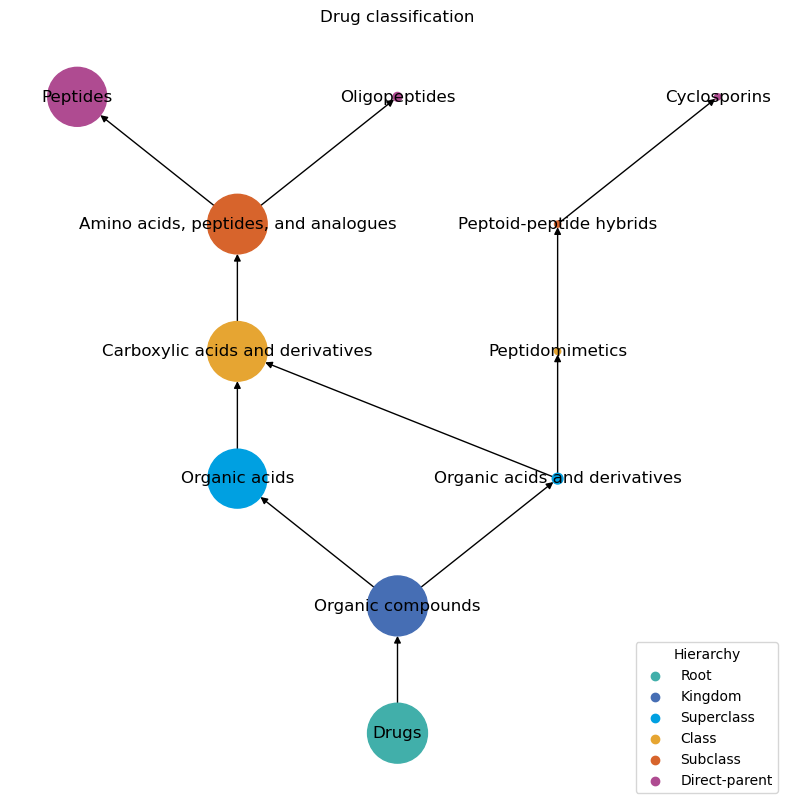

In [34]:
classification_tree()

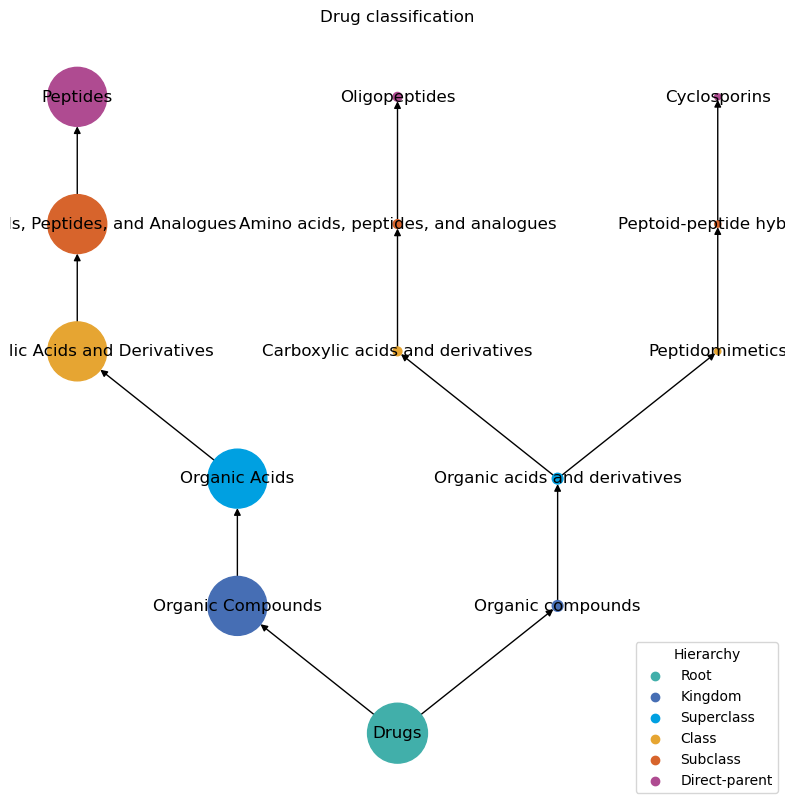

In [35]:
classification_tree(case_sensitive=True)